# 0. Install and Import Dependencies

In [1]:
# !pip list

In [2]:
%pip install opencv-python matplotlib imageio gdown tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
import imageio

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [7]:
import gdown

In [8]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=287568f3-bc5a-43f5-a634-e82d54f84f57
To: /kaggle/working/data.zip
100%|██████████| 423M/423M [00:04<00:00, 96.4MB/s] 


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [9]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)                        # read frames of the video
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()                         # ret-wheather frame is captured or not  , frame actual matrix representation of captured frame
        frame = tf.image.rgb_to_grayscale(frame)        # convert to grayscale
        frames.append(frame[190:236,80:220,:])          # Crop only mouth region and add pixel matrix to frame list
    cap.release()
    
    mean = tf.math.reduce_mean(frames )
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std   # standarrdize pixel values and make it float16 to reduce furthur computation times

In [10]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [11]:
# encode vocabs to its index and set every character that is not in vocab to empty strig 
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
# decode do the opposite of above 
num_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True)

print(f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [12]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [13]:
char_to_num(['o', 'm', 'm'])

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([15, 13, 13])>

In [14]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [15]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    # in every line there are 3 elemnts
    # 1st and 2nd are the time stamps during which word is said
    # 3rd is actual word that is said
    for line in lines:
        line = line.split()
        if line[2] != 'sil':                     # dont consider silence
            tokens = [*tokens,' ',line[2]] 
    # all encoded words are stored in tokens list so return their concatination to train model
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [16]:
def load_data(path: str): 
#     path = bytes.decode(path.numpy())
#     print(path)
    file_name = path.numpy().decode('utf-8').split('/')[-1].split('.')[0]
#     file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments
#     return file_name

In [17]:
test_path = './data/s1/srwv1s.mpg'

In [18]:
# test_path = bytes.decode(test_path.numpy())

In [19]:
# hi = tf.convert_to_tensor(test_path).numpy().decode('utf-8')
# hi

In [20]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'srwv1s'

In [21]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

In [22]:
alignments

<tf.Tensor: shape=(23,), dtype=int64, numpy=
array([19,  5, 20, 39, 18,  5,  4, 39, 23,  9, 20,  8, 39, 22, 39, 15, 14,
        5, 39, 19, 15, 15, 14])>

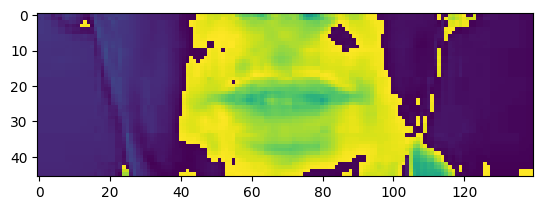

In [23]:
plt.imshow(frames[0])

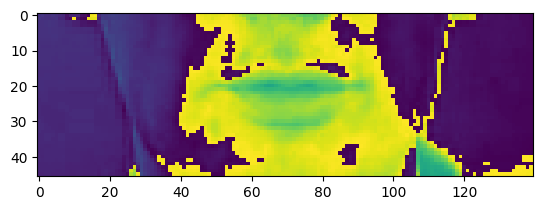

In [24]:
plt.imshow(frames[23])

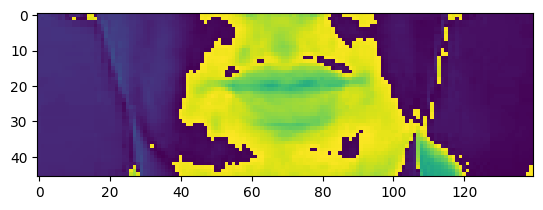

In [25]:
plt.imshow(frames[40])

In [26]:
alignments

<tf.Tensor: shape=(23,), dtype=int64, numpy=
array([19,  5, 20, 39, 18,  5,  4, 39, 23,  9, 20,  8, 39, 22, 39, 15, 14,
        5, 39, 19, 15, 15, 14])>

In [27]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'set red with v one soon'>

In [28]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [29]:
from matplotlib import pyplot as plt

In [30]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)


In [31]:
# Train - Test Split
train = data.take(450)
test = data.skip(450)

In [32]:
len(train)

450

In [33]:
frames, alignments = data.as_numpy_iterator().next()

In [34]:
len(frames)

2

In [35]:
sample = data.as_numpy_iterator()

In [36]:
val = sample.next()
val[0]

array([[[[[1.3697747 ],
          [1.3697747 ],
          [1.3697747 ],
          ...,
          [0.03702094],
          [0.2961675 ],
          [0.18510468]],

         [[1.3697747 ],
          [1.3697747 ],
          [1.3697747 ],
          ...,
          [0.14808375],
          [0.14808375],
          [0.07404187]],

         [[1.3327538 ],
          [1.3327538 ],
          [1.3327538 ],
          ...,
          [0.18510468],
          [0.14808375],
          [0.14808375]],

         ...,

         [[0.92552346],
          [0.92552346],
          [0.92552346],
          ...,
          [9.329276  ],
          [9.292255  ],
          [9.292255  ]],

         [[0.92552346],
          [0.92552346],
          [0.92552346],
          ...,
          [9.292255  ],
          [9.255235  ],
          [9.255235  ]],

         [[0.92552346],
          [0.92552346],
          [0.92552346],
          ...,
          [9.292255  ],
          [9.255235  ],
          [9.255235  ]]],


        [[[1.3697

In [37]:
val[0].shape

(2, 75, 46, 140, 1)

In [38]:
# imageio.mimsave('./animation.gif', val[0][0], fps=10)

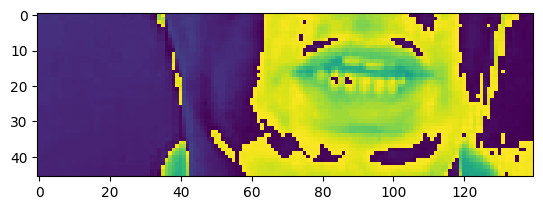

In [39]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][23])

In [40]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin white with b one again'>

# 3. Design the Deep Neural Network

In [41]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [42]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [43]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [45]:
5*17*75

6375

In [46]:
yhat = model.predict(val[0])

1/1 [==============================] - 4s 4s/step


In [47]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'555555555555555555555555555555555555555555555555555555555555555555555555ccc'>

In [48]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'555555555555555555555555555555555555555555555555555555555555555555555555ccc'>

In [49]:
model.input_shape

(None, 75, 46, 140, 1)

In [50]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [51]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [52]:
# define our special CTC loss function
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [53]:
# produce example original lable and predicted lable after each epoch to see model performance
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
#         if epoh == 1 or epoch % 4 == 0:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('-'*100)

In [54]:
# use adam optimizer
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [55]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [56]:
schedule_callback = LearningRateScheduler(scheduler)

In [57]:
example_callback = ProduceExample(test)

In [58]:
history = model.fit(train, validation_data=test, epochs=96, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/96
448/450 [============================>.] - ETA: 1s - loss: 85.3319

[mpeg1video @ 0x7d76940c7700] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76940c7700] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 85.2746

[mpeg1video @ 0x7d76ec030440] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76ec030440] Warning MVs not available
[mpeg1video @ 0x7d7768032a80] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7768032a80] Warning MVs not available


1/1 [==============================] - 2s 2s/step
Original: bin white at t two now
Prediction: le e e e e eo
----------------------------------------------------------------------------------------------------
Original: set white by o eight now
Prediction: le e e e e eo
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 739s 2s/step - loss: 85.2746 - val_loss: 69.1930 - lr: 1.0000e-04
Epoch 2/96
 68/450 [===>..........................] - ETA: 4:28 - loss: 73.4134

[mpeg1video @ 0x7d76b8053980] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76b8053980] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 70.9716

[mpeg1video @ 0x7d77940ad200] ac-tex damaged at 22 17
[mpeg1video @ 0x7d77940ad200] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Original: lay white at r nine again
Prediction: la e e e o o
----------------------------------------------------------------------------------------------------
Original: place blue with j three soon
Prediction: la e e e o o
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 533s 1s/step - loss: 70.9716 - val_loss: 65.6452 - lr: 1.0000e-04
Epoch 3/96
169/450 [==========>...................] - ETA: 3:16 - loss: 68.2471

[mpeg1video @ 0x7d7698203d00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7698203d00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 66.9147

[mpeg1video @ 0x7d76e40a8280] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76e40a8280] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Original: place white by d six now
Prediction: la e e i e eo
----------------------------------------------------------------------------------------------------
Original: lay red with l seven again
Prediction: la e e i e eo
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 533s 1s/step - loss: 66.9147 - val_loss: 62.2782 - lr: 1.0000e-04
Epoch 4/96
335/450 [=====================>........] - ETA: 1:20 - loss: 64.3567

[mpeg1video @ 0x7d786819c100] ac-tex damaged at 22 17
[mpeg1video @ 0x7d786819c100] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 63.9592

[mpeg1video @ 0x7d74efbb6340] ac-tex damaged at 22 17
[mpeg1video @ 0x7d74efbb6340] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Original: lay blue in d five again
Prediction: la re t e eo
----------------------------------------------------------------------------------------------------
Original: place blue in u nine soon
Prediction: la re t e eo
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 534s 1s/step - loss: 63.9592 - val_loss: 58.9128 - lr: 1.0000e-04
Epoch 5/96
104/450 [=====>........................] - ETA: 4:01 - loss: 62.2432

[mpeg1video @ 0x7d77681e9fc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d77681e9fc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 61.8173

[mpeg1video @ 0x7d76940a2e00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76940a2e00] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: set red in h one soon
Prediction: la re t e on
----------------------------------------------------------------------------------------------------
Original: bin white at m eight now
Prediction: la re t e on
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 533s 1s/step - loss: 61.8173 - val_loss: 58.2501 - lr: 1.0000e-04
Epoch 6/96
 95/450 [=====>........................] - ETA: 4:08 - loss: 60.6522

[mpeg1video @ 0x7d76e800bbc0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76e800bbc0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 60.1350

[mpeg1video @ 0x7d785009fe00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d785009fe00] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: set blue at a five soon
Prediction: la re i e on
----------------------------------------------------------------------------------------------------
Original: place white by d seven soon
Prediction: la re t e oa
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 534s 1s/step - loss: 60.1350 - val_loss: 55.6897 - lr: 1.0000e-04
Epoch 7/96
  3/450 [..............................] - ETA: 5:12 - loss: 61.2685

[mpeg1video @ 0x7d75e1f81940] ac-tex damaged at 22 17
[mpeg1video @ 0x7d75e1f81940] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 58.5690

[mpeg1video @ 0x7d76f8038e00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76f8038e00] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: set green by p seven again
Prediction: la re i e on
----------------------------------------------------------------------------------------------------
Original: lay blue at d nine again
Prediction: la re i e on
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 535s 1s/step - loss: 58.5690 - val_loss: 55.3017 - lr: 1.0000e-04
Epoch 8/96
128/450 [=======>......................] - ETA: 3:45 - loss: 57.1586

[mpeg1video @ 0x7d7684b6c000] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7684b6c000] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 55.7670

[mpeg1video @ 0x7d76b800cf00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76b800cf00] Warning MVs not available


1/1 [==============================] - 0s 122ms/step
Original: set white in o three again
Prediction: la re t e ae
----------------------------------------------------------------------------------------------------
Original: set green with q zero please
Prediction: la re t e ae
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 534s 1s/step - loss: 55.7670 - val_loss: 50.9557 - lr: 1.0000e-04
Epoch 9/96
  6/450 [..............................] - ETA: 5:05 - loss: 51.8333

[mpeg1video @ 0x7d78640a13c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d78640a13c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 52.7824

[mpeg1video @ 0x7d7698001600] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7698001600] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Original: bin blue in l three soon
Prediction: la re i e on
----------------------------------------------------------------------------------------------------
Original: bin green at u zero please
Prediction: la re t e aon
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 536s 1s/step - loss: 52.7824 - val_loss: 48.8146 - lr: 1.0000e-04
Epoch 10/96
117/450 [======>.......................] - ETA: 3:52 - loss: 51.7781

[mpeg1video @ 0x7d76f8069700] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76f8069700] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 50.8946

[mpeg1video @ 0x5646a2e28980] ac-tex damaged at 22 17
[mpeg1video @ 0x5646a2e28980] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: place red by x five again
Prediction: la re i e an
----------------------------------------------------------------------------------------------------
Original: lay white by f four please
Prediction: la re t e ae
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 534s 1s/step - loss: 50.8946 - val_loss: 46.5846 - lr: 1.0000e-04
Epoch 11/96
 71/450 [===>..........................] - ETA: 4:23 - loss: 49.8170

[mpeg1video @ 0x7d76b8015b00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76b8015b00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 49.0681

[mpeg1video @ 0x7d7794036140] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7794036140] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: bin blue at f four please
Prediction: set re b e pae
----------------------------------------------------------------------------------------------------
Original: bin green at t eight now
Prediction: set re i ie on
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 530s 1s/step - loss: 49.0681 - val_loss: 45.2084 - lr: 1.0000e-04
Epoch 12/96
450/450 [==============================] - ETA: 0s - loss: 47.0584

[mpeg1video @ 0x7d76f80a7680] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76f80a7680] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Original: lay blue in x six please
Prediction: la re t ie ae
----------------------------------------------------------------------------------------------------
Original: place red by x four please
Prediction: la re y e pase
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 531s 1s/step - loss: 47.0584 - val_loss: 41.4461 - lr: 1.0000e-04
Epoch 13/96
246/450 [===============>..............] - ETA: 2:22 - loss: 44.8250

[mpeg1video @ 0x7d7684d65180] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7684d65180] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 44.3900

[mpeg1video @ 0x7d76aa01d540] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76aa01d540] Warning MVs not available


1/1 [==============================] - 0s 130ms/step
Original: place white at d five again
Prediction: la re it ie ain
----------------------------------------------------------------------------------------------------
Original: lay red by e nine again
Prediction: la re y e aon
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 532s 1s/step - loss: 44.3900 - val_loss: 40.2157 - lr: 1.0000e-04
Epoch 14/96
377/450 [========================>.....] - ETA: 50s - loss: 42.6432

[mpeg1video @ 0x7d78500a1d80] ac-tex damaged at 22 17
[mpeg1video @ 0x7d78500a1d80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 42.5115

[mpeg1video @ 0x7d768806e180] ac-tex damaged at 22 17
[mpeg1video @ 0x7d768806e180] Warning MVs not available


1/1 [==============================] - 0s 120ms/step
Original: lay green in f three again
Prediction: la gre it ie ain
----------------------------------------------------------------------------------------------------
Original: bin blue with g two please
Prediction: la blue it oe plase
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 530s 1s/step - loss: 42.5115 - val_loss: 36.6420 - lr: 1.0000e-04
Epoch 15/96
 81/450 [====>.........................] - ETA: 4:16 - loss: 40.0415

[mpeg1video @ 0x7d76ec0af680] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76ec0af680] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 39.7808

[mpeg1video @ 0x7d78580c7300] ac-tex damaged at 22 17
[mpeg1video @ 0x7d78580c7300] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: set red at u two now
Prediction: la re it on ow
----------------------------------------------------------------------------------------------------
Original: lay green by m four please
Prediction: la re iy oe plese
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 532s 1s/step - loss: 39.7808 - val_loss: 34.9563 - lr: 1.0000e-04
Epoch 16/96
269/450 [================>.............] - ETA: 2:06 - loss: 38.0795

[mpeg1video @ 0x7d76b295e5c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76b295e5c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 37.8971

[mpeg1video @ 0x7d76fc0b7340] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76fc0b7340] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: place red with d four now
Prediction: la gre it o ow
----------------------------------------------------------------------------------------------------
Original: lay green in l six please
Prediction: set gre it o plase
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 531s 1s/step - loss: 37.8971 - val_loss: 31.5592 - lr: 1.0000e-04
Epoch 17/96
 42/450 [=>............................] - ETA: 4:40 - loss: 37.2339

[mpeg1video @ 0x7d7694076200] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7694076200] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 35.7804

[mpeg1video @ 0x7d76e804c340] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76e804c340] Warning MVs not available


1/1 [==============================] - 0s 125ms/step
Original: place green with l two please
Prediction: pla gre it o plase
----------------------------------------------------------------------------------------------------
Original: set white by v five again
Prediction: sit whie by ie ain
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 526s 1s/step - loss: 35.7804 - val_loss: 30.6613 - lr: 1.0000e-04
Epoch 18/96
317/450 [====================>.........] - ETA: 1:31 - loss: 33.3841

[mpeg1video @ 0x7d7864073480] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7864073480] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 33.3151

[mpeg1video @ 0x7d75e1fa4540] ac-tex damaged at 22 17
[mpeg1video @ 0x7d75e1fa4540] Warning MVs not available


1/1 [==============================] - 0s 123ms/step
Original: place white at q zero now
Prediction: plac blue it o now
----------------------------------------------------------------------------------------------------
Original: place white in x zero now
Prediction: plac whie it o now
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 527s 1s/step - loss: 33.3151 - val_loss: 27.6424 - lr: 1.0000e-04
Epoch 19/96
 45/450 [==>...........................] - ETA: 4:39 - loss: 31.6894

[mpeg1video @ 0x7d7768044b80] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7768044b80] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 30.8727

[mpeg1video @ 0x7d7684b7ea80] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7684b7ea80] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: bin red in f seven again
Prediction: set red it ne ain
----------------------------------------------------------------------------------------------------
Original: lay blue with y six now
Prediction: pla blue it ie now
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 526s 1s/step - loss: 30.8727 - val_loss: 26.3044 - lr: 1.0000e-04
Epoch 20/96
 49/450 [==>...........................] - ETA: 4:37 - loss: 29.1554

[mpeg1video @ 0x7d76e402d840] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76e402d840] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 28.5955

[mpeg1video @ 0x7d784c0c5140] ac-tex damaged at 22 17
[mpeg1video @ 0x7d784c0c5140] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Original: bin white by n three soon
Prediction: bit white bt hre son
----------------------------------------------------------------------------------------------------
Original: set white with v seven soon
Prediction: set whie it ie son
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 527s 1s/step - loss: 28.5955 - val_loss: 23.0497 - lr: 1.0000e-04
Epoch 21/96
 80/450 [====>.........................] - ETA: 4:15 - loss: 25.9200

[mpeg1video @ 0x7d76a404f1c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76a404f1c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 26.3424

[mpeg1video @ 0x7d76f4088780] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76f4088780] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: set white at v zero please
Prediction: sit white at zo please
----------------------------------------------------------------------------------------------------
Original: place white with k four now
Prediction: place whie wit ro now
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 529s 1s/step - loss: 26.3424 - val_loss: 20.3814 - lr: 1.0000e-04
Epoch 22/96
 75/450 [====>.........................] - ETA: 4:20 - loss: 24.0886

[mpeg1video @ 0x7d76880ba700] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76880ba700] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 24.4883

[mpeg1video @ 0x7d76bc0c2680] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76bc0c2680] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: place blue at p zero please
Prediction: place blue at ro please
----------------------------------------------------------------------------------------------------
Original: place green at e one again
Prediction: place gren an ne ain
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 529s 1s/step - loss: 24.4883 - val_loss: 18.4825 - lr: 1.0000e-04
Epoch 23/96
223/450 [=============>................] - ETA: 2:37 - loss: 22.7817

[mpeg1video @ 0x7d785009eac0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d785009eac0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 22.5235

[mpeg1video @ 0x7d76a4078680] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76a4078680] Warning MVs not available


1/1 [==============================] - 0s 124ms/step
Original: lay green with t zero now
Prediction: place gre wit er now
----------------------------------------------------------------------------------------------------
Original: lay red at y four now
Prediction: lay red at or now
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 531s 1s/step - loss: 22.5235 - val_loss: 17.3327 - lr: 1.0000e-04
Epoch 24/96
 52/450 [==>...........................] - ETA: 4:38 - loss: 21.2628

[mpeg1video @ 0x7d76f4037f40] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76f4037f40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 20.8805

[mpeg1video @ 0x7d785803cc40] ac-tex damaged at 22 17
[mpeg1video @ 0x7d785803cc40] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: place red in v seven again
Prediction: place red in eve again
----------------------------------------------------------------------------------------------------
Original: set white in o one soon
Prediction: set white in oe son
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 531s 1s/step - loss: 20.8805 - val_loss: 15.4639 - lr: 1.0000e-04
Epoch 25/96
 34/450 [=>............................] - ETA: 4:46 - loss: 20.7000

[mpeg1video @ 0x7d76b8079e00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76b8079e00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 19.3281

[mpeg1video @ 0x7d776808e3c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d776808e3c0] Warning MVs not available


1/1 [==============================] - 0s 118ms/step
Original: set white with c four now
Prediction: bit white wit or now
----------------------------------------------------------------------------------------------------
Original: place green in k zero please
Prediction: place gren in zor please
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 528s 1s/step - loss: 19.3281 - val_loss: 15.1650 - lr: 1.0000e-04
Epoch 26/96
 52/450 [==>...........................] - ETA: 4:38 - loss: 17.5392

[mpeg1video @ 0x7d769405f000] ac-tex damaged at 22 17
[mpeg1video @ 0x7d769405f000] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 17.7996

[mpeg1video @ 0x7d76e40858c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76e40858c0] Warning MVs not available


1/1 [==============================] - 0s 122ms/step
Original: place red by j six please
Prediction: place red by six please
----------------------------------------------------------------------------------------------------
Original: bin white in g zero now
Prediction: bin white in zr now
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 527s 1s/step - loss: 17.7996 - val_loss: 12.4896 - lr: 1.0000e-04
Epoch 27/96
395/450 [=========================>....] - ETA: 38s - loss: 16.5832

[mpeg1video @ 0x7d78640b03c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d78640b03c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 16.5271

[mpeg1video @ 0x7d76a001ce00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76a001ce00] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: place blue by j zero please
Prediction: place blue by eor please
----------------------------------------------------------------------------------------------------
Original: set green with p nine soon
Prediction: set gren with ine son
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 527s 1s/step - loss: 16.5271 - val_loss: 11.0701 - lr: 1.0000e-04
Epoch 28/96
257/450 [================>.............] - ETA: 2:13 - loss: 14.8020

[mpeg1video @ 0x7d776804a0c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d776804a0c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 15.0045

[mpeg1video @ 0x7d7694076100] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7694076100] Warning MVs not available


1/1 [==============================] - 0s 122ms/step
Original: lay blue by k seven again
Prediction: lay blue by seve again
----------------------------------------------------------------------------------------------------
Original: set blue at g eight now
Prediction: set blue at eght now
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 529s 1s/step - loss: 15.0045 - val_loss: 10.2751 - lr: 1.0000e-04
Epoch 29/96
339/450 [=====================>........] - ETA: 1:16 - loss: 14.0662

[mpeg1video @ 0x7d76e40240c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76e40240c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 14.0592

[mpeg1video @ 0x7d78481301c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d78481301c0] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Original: lay blue in q one soon
Prediction: lay blue in ne son
----------------------------------------------------------------------------------------------------
Original: lay green in f one soon
Prediction: lay gren in ne son
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 529s 1s/step - loss: 14.0592 - val_loss: 9.1001 - lr: 1.0000e-04
Epoch 30/96
412/450 [==========================>...] - ETA: 26s - loss: 13.1332

[mpeg1video @ 0x7d74efc73340] ac-tex damaged at 22 17
[mpeg1video @ 0x7d74efc73340] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 13.1728

[mpeg1video @ 0x7d76f800a380] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76f800a380] Warning MVs not available


1/1 [==============================] - 0s 119ms/step
Original: place blue by c five soon
Prediction: place blue by five son
----------------------------------------------------------------------------------------------------
Original: place green by e three soon
Prediction: place gren by tre son
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 530s 1s/step - loss: 13.1728 - val_loss: 9.4078 - lr: 1.0000e-04
Epoch 31/96
118/450 [======>.......................] - ETA: 3:50 - loss: 12.5134

[mpeg1video @ 0x5646a3268900] ac-tex damaged at 22 17
[mpeg1video @ 0x5646a3268900] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 12.3935

[mpeg1video @ 0x7d76b2406900] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76b2406900] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Original: set blue at n three soon
Prediction: set blue at tre son
----------------------------------------------------------------------------------------------------
Original: place white at j eight please
Prediction: place white at eiht please
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 530s 1s/step - loss: 12.3935 - val_loss: 8.2575 - lr: 9.0484e-05
Epoch 32/96
  8/450 [..............................] - ETA: 5:05 - loss: 10.7112

[mpeg1video @ 0x7d785001af00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d785001af00] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 11.1808

[mpeg1video @ 0x7d76a40aa880] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76a40aa880] Warning MVs not available


1/1 [==============================] - 0s 120ms/step
Original: set white in b four please
Prediction: set white in b for please
----------------------------------------------------------------------------------------------------
Original: set blue at t nine again
Prediction: set blue at t ne again
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 528s 1s/step - loss: 11.1808 - val_loss: 7.8103 - lr: 8.1873e-05
Epoch 33/96
450/450 [==============================] - ETA: 0s - loss: 10.4560

[mpeg1video @ 0x5646ae05ac00] ac-tex damaged at 22 17
[mpeg1video @ 0x5646ae05ac00] Warning MVs not available


1/1 [==============================] - 0s 120ms/step
Original: bin blue by f nine again
Prediction: bin blue by nine again
----------------------------------------------------------------------------------------------------
Original: lay red at e two now
Prediction: lay red at two now
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 531s 1s/step - loss: 10.4560 - val_loss: 6.9572 - lr: 7.4082e-05
Epoch 34/96
232/450 [==============>...............] - ETA: 2:31 - loss: 9.7544

[mpeg1video @ 0x7d76bc038640] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76bc038640] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 9.8701

[mpeg1video @ 0x7d7768196a00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7768196a00] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: lay red at k seven soon
Prediction: lay red at seve son
----------------------------------------------------------------------------------------------------
Original: set blue in g five soon
Prediction: set blue in five son
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 530s 1s/step - loss: 9.8701 - val_loss: 6.6227 - lr: 6.7032e-05
Epoch 35/96
 49/450 [==>...........................] - ETA: 4:38 - loss: 9.0996

[mpeg1video @ 0x7d769008d9c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d769008d9c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 9.0793

[mpeg1video @ 0x7d76ec057840] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76ec057840] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Original: lay white sp by f three soon
Prediction: lay white by tre son
----------------------------------------------------------------------------------------------------
Original: lay red at k six now
Prediction: lay red at six now
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 530s 1s/step - loss: 9.0793 - val_loss: 5.7344 - lr: 6.0653e-05
Epoch 36/96
399/450 [=========================>....] - ETA: 35s - loss: 8.5103

[mpeg1video @ 0x5646a30a45c0] ac-tex damaged at 22 17
[mpeg1video @ 0x5646a30a45c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.4954

[mpeg1video @ 0x7d76b2946780] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76b2946780] Warning MVs not available


1/1 [==============================] - 0s 125ms/step
Original: bin red in s two now
Prediction: bin red in wo now
----------------------------------------------------------------------------------------------------
Original: place green at d nine soon
Prediction: place gren at ne son
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 533s 1s/step - loss: 8.4954 - val_loss: 4.9208 - lr: 5.4881e-05
Epoch 37/96
 92/450 [=====>........................] - ETA: 4:09 - loss: 8.1721

[mpeg1video @ 0x7d7794003400] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7794003400] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 8.0987

[mpeg1video @ 0x7d76880bfc00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76880bfc00] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Original: bin green by b one soon
Prediction: bin gren by b one son
----------------------------------------------------------------------------------------------------
Original: lay blue by k five soon
Prediction: lay blue by five son
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 533s 1s/step - loss: 8.0987 - val_loss: 5.0810 - lr: 4.9659e-05
Epoch 38/96
268/450 [================>.............] - ETA: 2:07 - loss: 7.7783

[mpeg1video @ 0x7d76e40b6b40] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76e40b6b40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.6377

[mpeg1video @ 0x7d7858023c00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7858023c00] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: set green with p eight now
Prediction: set gren with p eight now
----------------------------------------------------------------------------------------------------
Original: lay white with m zero now
Prediction: lay white with zero now
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 531s 1s/step - loss: 7.6377 - val_loss: 4.6688 - lr: 4.4933e-05
Epoch 39/96
194/450 [===========>..................] - ETA: 2:57 - loss: 7.4151

[mpeg1video @ 0x7d76b24df880] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76b24df880] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 7.3532

[mpeg1video @ 0x7d76fc06c080] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76fc06c080] Warning MVs not available


1/1 [==============================] - 0s 113ms/step
Original: place green by y four now
Prediction: place gren by y four now
----------------------------------------------------------------------------------------------------
Original: set green with x three soon
Prediction: set gren with thre son
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 530s 1s/step - loss: 7.3532 - val_loss: 4.1540 - lr: 4.0657e-05
Epoch 40/96
 53/450 [==>...........................] - ETA: 4:35 - loss: 6.7174

[mpeg1video @ 0x7d7688005140] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7688005140] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.9693

[mpeg1video @ 0x7d76b802b2c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76b802b2c0] Warning MVs not available


1/1 [==============================] - 0s 114ms/step
Original: set green by j two please
Prediction: set gren by two please
----------------------------------------------------------------------------------------------------
Original: set red with v one soon
Prediction: set red with one son
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 528s 1s/step - loss: 6.9693 - val_loss: 3.7644 - lr: 3.6788e-05
Epoch 41/96
 49/450 [==>...........................] - ETA: 4:38 - loss: 6.5841

[mpeg1video @ 0x7d7858b4be40] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7858b4be40] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.5354

[mpeg1video @ 0x7d76a4017d00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76a4017d00] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: bin green at a seven soon
Prediction: bin gren at a seven son
----------------------------------------------------------------------------------------------------
Original: lay blue at q four now
Prediction: lay blue at four now
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 529s 1s/step - loss: 6.5354 - val_loss: 3.7980 - lr: 3.3287e-05
Epoch 42/96
354/450 [======================>.......] - ETA: 1:06 - loss: 6.2998

[mpeg1video @ 0x7d77681a79c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d77681a79c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.3091

[mpeg1video @ 0x7d786819a040] ac-tex damaged at 22 17
[mpeg1video @ 0x7d786819a040] Warning MVs not available


1/1 [==============================] - 0s 120ms/step
Original: set red by b seven again
Prediction: set red by b seven again
----------------------------------------------------------------------------------------------------
Original: bin green in a three soon
Prediction: bin gren in a thre son
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 529s 1s/step - loss: 6.3091 - val_loss: 3.4402 - lr: 3.0119e-05
Epoch 43/96
222/450 [=============>................] - ETA: 2:38 - loss: 6.1450

[mpeg1video @ 0x7d76bc0112c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76bc0112c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 6.1269

[mpeg1video @ 0x7d78501a6200] ac-tex damaged at 22 17
[mpeg1video @ 0x7d78501a6200] Warning MVs not available


1/1 [==============================] - 0s 127ms/step
Original: bin green by h seven again
Prediction: bin gren by seven again
----------------------------------------------------------------------------------------------------
Original: set red with b eight now
Prediction: set red with b eight now
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 529s 1s/step - loss: 6.1269 - val_loss: 3.5841 - lr: 2.7253e-05
Epoch 44/96
450/450 [==============================] - ETA: 0s - loss: 5.8158

[mpeg1video @ 0x7d76f00ab4c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76f00ab4c0] Warning MVs not available


1/1 [==============================] - 0s 121ms/step
Original: place white at x four now
Prediction: place white at four now
----------------------------------------------------------------------------------------------------
Original: place green by k eight please
Prediction: place gren by eight please
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 529s 1s/step - loss: 5.8158 - val_loss: 2.9137 - lr: 2.4660e-05
Epoch 45/96
 49/450 [==>...........................] - ETA: 4:39 - loss: 5.7414

[mpeg1video @ 0x7d78600ae000] ac-tex damaged at 22 17
[mpeg1video @ 0x7d78600ae000] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.5908

[mpeg1video @ 0x7d76aa2270c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76aa2270c0] Warning MVs not available


1/1 [==============================] - 0s 124ms/step
Original: set red at h six please
Prediction: set red at h six please
----------------------------------------------------------------------------------------------------
Original: bin white at t four please
Prediction: bin white at t four please
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 529s 1s/step - loss: 5.5908 - val_loss: 3.5077 - lr: 2.2313e-05
Epoch 46/96
 31/450 [=>............................] - ETA: 4:49 - loss: 6.2382

[mpeg1video @ 0x7d7794062580] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7794062580] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.5060

[mpeg1video @ 0x7d76980640c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76980640c0] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: place red in c four please
Prediction: place red in c four please
----------------------------------------------------------------------------------------------------
Original: bin blue in r nine again
Prediction: bin blue in r nine again
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 528s 1s/step - loss: 5.5060 - val_loss: 2.7765 - lr: 2.0190e-05
Epoch 47/96
115/450 [======>.......................] - ETA: 3:52 - loss: 5.1303

[mpeg1video @ 0x7d76f0060900] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76f0060900] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.3135

[mpeg1video @ 0x7d78640597c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d78640597c0] Warning MVs not available


1/1 [==============================] - 0s 115ms/step
Original: place white at j six now
Prediction: place white at six now
----------------------------------------------------------------------------------------------------
Original: place blue in o five soon
Prediction: place blue in five son
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 528s 1s/step - loss: 5.3135 - val_loss: 2.7981 - lr: 1.8268e-05
Epoch 48/96
424/450 [===========================>..] - ETA: 18s - loss: 5.0985

[mpeg1video @ 0x7d76bc027000] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76bc027000] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.0879

[mpeg1video @ 0x7d76fc082d40] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76fc082d40] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: set white with p two now
Prediction: set white with p two now
----------------------------------------------------------------------------------------------------
Original: lay red by r five soon
Prediction: lay red by five son
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 529s 1s/step - loss: 5.0879 - val_loss: 2.4640 - lr: 1.6530e-05
Epoch 49/96
 86/450 [====>.........................] - ETA: 4:12 - loss: 5.0373

[mpeg1video @ 0x7d76880410c0] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76880410c0] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 5.0412

[mpeg1video @ 0x7d76c0072080] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76c0072080] Warning MVs not available


1/1 [==============================] - 0s 117ms/step
Original: bin white with h four please
Prediction: bin white with four please
----------------------------------------------------------------------------------------------------
Original: place blue in o four now
Prediction: place blue in o four now
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 527s 1s/step - loss: 5.0412 - val_loss: 2.2985 - lr: 1.4957e-05
Epoch 50/96
222/450 [=============>................] - ETA: 2:38 - loss: 5.0053

[mpeg1video @ 0x7d7864210200] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7864210200] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 4.9653

[mpeg1video @ 0x7d76a0059700] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76a0059700] Warning MVs not available


1/1 [==============================] - 0s 116ms/step
Original: bin green by u five again
Prediction: bin gren by u five again
----------------------------------------------------------------------------------------------------
Original: bin blue by s six please
Prediction: bin blue by s six please
----------------------------------------------------------------------------------------------------
450/450 [==============================] - 528s 1s/step - loss: 4.9653 - val_loss: 2.2633 - lr: 1.3534e-05
Epoch 51/96
 75/450 [====>.........................] - ETA: 4:19 - loss: 4.6747

[mpeg1video @ 0x7d76f4059200] ac-tex damaged at 22 17
[mpeg1video @ 0x7d76f4059200] Warning MVs not available


450/450 [==============================] - ETA: 0s - loss: 4.8409

[mpeg1video @ 0x7d7688207f00] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7688207f00] Warning MVs not available


StopIteration: 

In [75]:
# history

In [78]:
training_loss = [85.2746 ,70.9716 ,66.9147 ,63.9592 ,61.8173 ,60.1350 ,58.5690 ,55.7670 ,52.7824 ,50.8946 ,49.0681 ,47.0584 ,44.3900 ,42.5115 ,39.7808 ,37.8971 ,35.7804 ,33.3151 ,30.8727 ,28.5955 ,26.3424 ,24.4883 ,22.5235 ,20.8805 ,19.3281 ,17.7996 ,16.5271 ,15.0045 ,14.0592,13.1728 ,12.3935 ,11.1808 ,10.4560 ,9.8701 ,9.0793 ,8.4954 ,8.0987 ,7.6377 ,7.3532 ,6.9693 ,6.5354 ,6.3091 ,6.1269 ,5.8158 ,5.5908 ,5.5060 ,5.3135 ,5.0879 ,5.0412 ,4.9653 ]
validation_loss = [69.1930 ,65.6452 ,62.2782 ,63.9592 ,58.2501 ,55.6897 ,55.3017 ,50.9557 ,48.8146 ,46.5846 ,45.2084 ,41.4461 ,40.2157 ,36.6420 ,34.9563 ,31.5592 ,35.7804 ,27.6424 ,26.3044 ,23.0497 ,20.3814 ,18.4825 ,17.3327 ,15.4639 ,15.1650 ,12.4896 ,11.0701 ,10.2751 ,9.1001 ,9.4078 ,8.2575 ,7.8103 ,6.9572 ,6.6227 ,5.7344 ,4.9208 ,5.0810 ,4.6688 ,4.1540 ,3.7644 ,3.7980 ,3.4402 ,3.5841 ,2.9137 ,3.5077 ,2.7765 ,2.7981 ,2.4640 ,2.2985 ,2.2633 ]

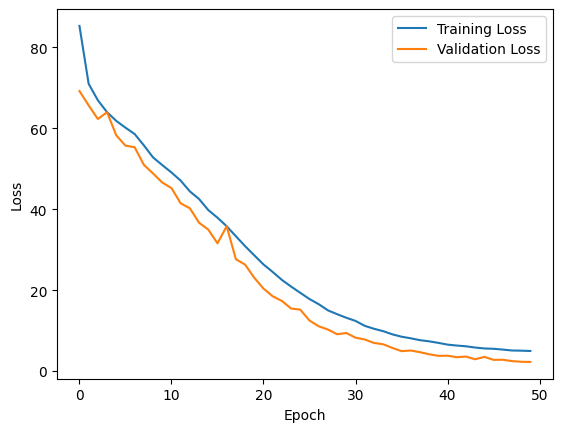

In [79]:

# Plot the loss
plt.figure()
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 5. Make a Prediction 

In [ ]:
# url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
# output = 'checkpoints.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('checkpoints.zip', 'models')

In [ ]:
# model.load_weights('./models/checkpoint')

In [80]:
test_data = test.as_numpy_iterator()

In [81]:
sample = test_data.next()

[mpeg1video @ 0x7d7690060740] ac-tex damaged at 22 17
[mpeg1video @ 0x7d7690060740] Warning MVs not available


In [82]:
sample[0].shape

(2, 75, 46, 140, 1)

In [83]:
sample[1].shape

(2, 40)

In [84]:
sample[1]

array([[16, 12,  1,  3,  5, 39,  7, 18,  5,  5, 14, 39,  9, 14, 39, 17,
        39,  6, 15, 21, 18, 39, 16, 12,  5,  1, 19,  5,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [19,  5, 20, 39,  2, 12, 21,  5, 39,  2, 25, 39,  8, 39, 20, 23,
        15, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [85]:
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 123ms/step


In [86]:
print('-'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

---------------------------------------------------------------------------------------------------- REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green in q four please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set blue by h two now'>]

In [87]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [88]:
print('-'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

---------------------------------------------------------------------------------------------------- PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place green in four please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set blue by h two now'>]

# Test on a Video

In [89]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [90]:
print('-'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

---------------------------------------------------------------------------------------------------- REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [91]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 0s 83ms/step


In [92]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [93]:
print('-'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

---------------------------------------------------------------------------------------------------- PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]